In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import defmod.registrationdata as regdata

torch.set_default_tensor_type(torch.DoubleTensor)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
dim = 2
origin = [[0.,0.], [10.,0.]]
radius = [2., 1.]
nb_pts = [10, 7]

data = regdata.PointCircles()
#data(nb_pts, origin, radius, transvec = [[10., 0.], [-10.,0.]], scal=1)
data(nb_pts, origin, radius, transvec = [[0., 5.], [0.,-5.]], scal=1)


source = data.source
target = data.target

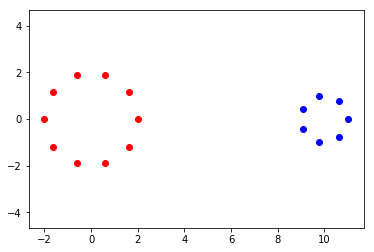

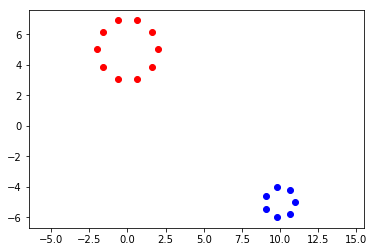

In [3]:
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
# Defining the deformation modules
sigma1 = 3
manifold1 = dm.manifold.Landmarks(dim, nb_pts[0], gd=source[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
mod1 = dm.deformationmodules.CompoundModule([trans1])


sigma2 = 3
manifold2 = dm.manifold.Landmarks(dim, nb_pts[1], gd=source[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
mod2 = dm.deformationmodules.CompoundModule([trans2])

module_list = [mod1, mod2]
sigma_bg = 0.1

modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [5]:
constr_Id = dm.constraints.Identity()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [6]:
my_model = dm.models.ModelMultishapePointsRegistration(source, [trans1, trans2], sigma_bg,  dm.attachement.L2NormAttachement_multi(), constr_Id)
costs = my_model.fit(target, lr=1e-4, l=1e5, max_iter=200, log_interval=5)

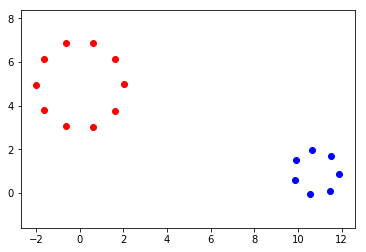

In [8]:
my_model.compute(target)
shot_gd = my_model()

plt.scatter(shot_gd[0].view(-1,2)[:, 0].detach().numpy(),shot_gd[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(shot_gd[1].view(-1,2)[:, 0].detach().numpy(),shot_gd[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')
plt.show()

In [9]:
out = my_model()
%matplotlib qt5
#plt.subplot(1, 2, 1)
#dm.usefulfunctions.plot_tensor_scatter(target[0], alpha=0.4)
#dm.usefulfunctions.plot_tensor_scatter(source[0], alpha=0.4)
#ax = plt.subplot(1, 2, 2)
#dm.usefulfunctions.plot_tensor_scatter(target[0], alpha=0.4)
#dm.usefulfunctions.plot_tensor_scatter(out[0][0], alpha=0.4)
#plt.plot(my_model.shot_manifold[1].gd[0].detach().view(-1, 2)[:, 1].numpy(), my_model.shot_manifold[1].gd[0].detach().view(-1, 2)[:, 0].numpy(), '.')
#plt.plot(my_model.shot_manifold[2].gd[0].detach().view(-1, 2)[:, 1].numpy(), my_model.shot_manifold[2].gd[0].detach().view(-1, 2)[:, 0].numpy(), '.')
gridpos_x, gridpos_y = my_model.compute_deformation_grid(torch.tensor([-2, -2]), torch.tensor([12, 12]), torch.tensor([16, 16]))
dm.usefulfunctions.plot_grid(ax, gridpos_y.detach().numpy(), gridpos_x.detach().numpy(), color='C0')
plt.show()


TypeError: div(): argument 'other' (position 1) must be Tensor, not list

In [10]:
# Why??
print(H.module.manifold.gd[0].view(-1) - shot_gd[0].view(-1))
print(H.module.manifold.gd[1].view(-1) - shot_gd[1].view(-1))
print(H.module.manifold.gd[2][0].view(-1) - shot_gd[2][0].view(-1))
print(H.module.manifold.gd[2][1].view(-1) - shot_gd[2][1].view(-1))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SubBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SubBackward0>)
tensor([-2.7533e-02, -4.9696e+00, -1.2984e-02, -4.9731e+00,  4.7856e-04,
        -4.9629e+00,  3.1383e-03, -4.9571e+00,  2.5107e-03, -4.9553e+00,
        -2.1470e-03, -4.9590e+00, -3.0652e-03, -4.9666e+00,  5.4777e-03,
        -4.9516e+00,  4.1853e-03, -4.9349e+00, -1.6875e-02, -4.9485e+00],
       grad_fn=<SubBackward0>)
tensor([-0.8934, -0.8532, -0.9043, -0.9176, -0.8597, -1.0066, -0.7997, -1.0615,
        -0.7632, -1.0275, -0.7736, -0.9259, -0.8315, -0.8510],
       grad_fn=<SubBackward0>)


In [9]:
grid_origin = [0,0]
grid_size = [10,10]
grid_resolution = [16, 16]

x, y = torch.meshgrid([
            torch.linspace(grid_origin[0], grid_origin[0]+grid_size[0], grid_resolution[0]),
            torch.linspace(grid_origin[1], grid_origin[1]+grid_size[1], grid_resolution[1])])

gridpos = dm.usefulfunctions.grid2vec(x, y)

grid_landmarks = dm.manifold.Landmarks(2, gridpos.shape[0], gd=gridpos.view(-1))
grid_silent = dm.deformationmodules.SilentPoints(grid_landmarks)
        
boundary_labels = [np.zeros(grid_landmarks.nb_pts), *[np.ones(mod.manifold.nb_pts) for mod in module_list]]
        
multi_silent = dm.multishape.MultiShapeModule([grid_silent, *module_list], sigma_bg, boundary_labels)

In [7]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
                
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)


test_gradcheck_Hamiltonian()

True

In [15]:
def test_gradcheck_model():
    def model(gd0, gd1, mom0, mom1):
        
        module_list[0].manifold.fill_gd(gd0)
        module_list[0].manifold.fill_cotan(mom0)
        module_list[1].manifold.fill_gd(gd1)
        module_list[1].manifold.fill_cotan(mom1)
        
        model = dm.models.ModelMultishapePointsRegistration(source, module_list, sigma_bg,  dm.attachement.L2NormAttachement_multi(), constr_Id)
        model.compute()
        
        return model.attach
    return torch.autograd.gradcheck(model, (gd[0], gd[1], mom[0], mom[1]), raise_exception=True)

gd = [torch.zeros(mod.manifold.numel_gd, requires_grad=True) for mod in module_list]
mom = [torch.zeros(mod.manifold.numel_gd, requires_grad=True) for mod in module_list]

print(gd)

test_gradcheck_Hamiltonian()

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)]


ValueError: gradcheck expects at least one input tensor to require gradient, but none of the them have requires_grad=True.